<img src="Credit One Logo.png" />

In [1]:
import pandas as pd
import numpy as np
import scipy
from math import sqrt
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

#estimators
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

#model metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

#cross validation
from sklearn.model_selection import train_test_split

# Importing Data

### Data was preprocessed and features selected during C5T2.  I've chosen to only use features that would be available at the decision point.  History of payments and billed amounts won't yet exist, so we must rely upon on what we know about the customer.

In [2]:
#data
rawData = pd.read_csv(r'C:\Users\jlegner\Desktop\Data Analytics\Data Analytics Class\Course 5\Task 3\creditModel.csv', header=1)
rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,limit_bin,age_bin,default payment next month
0,20000,2,2,1,24,"(9999.999, 30000.0]","(20.999, 26.0]",1
1,120000,2,2,2,26,"(100000.0, 140000.0]","(20.999, 26.0]",1
2,90000,2,2,2,34,"(70000.0, 100000.0]","(30.0, 34.0]",0
3,50000,2,2,1,37,"(30000.0, 50000.0]","(34.0, 39.0]",0
4,50000,1,2,1,57,"(30000.0, 50000.0]","(45.0, 79.0]",0


In [3]:
rawData.info

<bound method DataFrame.info of        LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE             limit_bin  \
0          20000    2          2         1   24   (9999.999, 30000.0]   
1         120000    2          2         2   26  (100000.0, 140000.0]   
2          90000    2          2         2   34   (70000.0, 100000.0]   
3          50000    2          2         1   37    (30000.0, 50000.0]   
4          50000    1          2         1   57    (30000.0, 50000.0]   
...          ...  ...        ...       ...  ...                   ...   
29995     220000    1          3         1   39  (210000.0, 270000.0]   
29996     150000    1          3         2   43  (140000.0, 180000.0]   
29997      30000    1          2         2   37   (9999.999, 30000.0]   
29998      80000    1          3         1   41   (70000.0, 100000.0]   
29999      50000    1          2         1   46    (30000.0, 50000.0]   

              age_bin  default payment next month  
0      (20.999, 26.0]                  

In [4]:
rawData['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [5]:
#Upsample
rawData_majority = rawData[rawData['default payment next month']==0]
rawData_minority = rawData[rawData['default payment next month']==1]

rawData_minority_upsampled = resample(rawData_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=23364,    # to match majority class
                                     random_state=123) # reproducible results

rawData_upsampled = pd.concat([rawData_majority, rawData_minority_upsampled])

rawData_upsampled['default payment next month'].value_counts()

1    23364
0    23364
Name: default payment next month, dtype: int64

# Set Dependent/Independent and Train/Test Split

In [6]:
#features
features = rawData_upsampled.iloc[:,0:7]
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,limit_bin,age_bin
2,90000,2,2,2,34,"(70000.0, 100000.0]","(30.0, 34.0]"
3,50000,2,2,1,37,"(30000.0, 50000.0]","(34.0, 39.0]"
4,50000,1,2,1,57,"(30000.0, 50000.0]","(45.0, 79.0]"
5,50000,1,1,2,37,"(30000.0, 50000.0]","(34.0, 39.0]"
6,500000,1,1,2,29,"(360000.0, 1000000.0]","(26.0, 30.0]"


In [7]:
features['SEX'] = pd.Categorical(features.SEX)
features['EDUCATION'] = pd.Categorical(features.EDUCATION)
features['MARRIAGE'] = pd.Categorical(features.MARRIAGE)
features['limit_bin'] = pd.Categorical(features.limit_bin)
features['age_bin'] = pd.Categorical(features.age_bin)
features.dtypes

LIMIT_BAL       int64
SEX          category
EDUCATION    category
MARRIAGE     category
AGE             int64
limit_bin    category
age_bin      category
dtype: object

In [8]:
#dependent variable
depVar = rawData_upsampled['default payment next month']
depVarCat = pd.Categorical(depVar)
print(depVar)
print(depVarCat)

2        0
3        0
4        0
5        0
6        0
        ..
2243     1
27216    1
23617    1
1569     1
5626     1
Name: default payment next month, Length: 46728, dtype: int64
[0, 0, 0, 0, 0, ..., 1, 1, 1, 1, 1]
Length: 46728
Categories (2, int64): [0, 1]


# Covariance

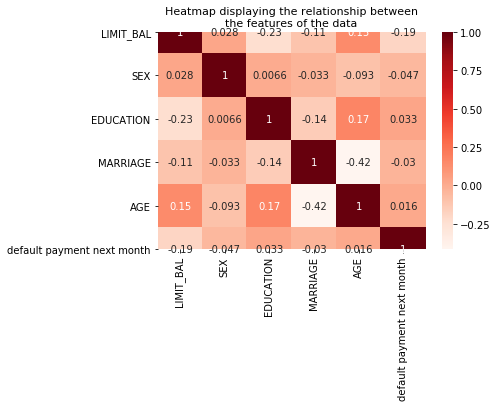

In [9]:
sn.heatmap(rawData_upsampled.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between\nthe features of the data',
         fontsize=11)
plt.show()

### Noted that none of our variables exhibit a high enough covariance to require them to be removed.

# EDA

# Feature Engineering

In [10]:
featuresDummy=pd.get_dummies(features, columns=['age_bin', 'limit_bin'])
featuresClean=featuresDummy.drop(['LIMIT_BAL', 'AGE'], axis=1)
print(featuresClean)

      SEX EDUCATION MARRIAGE  age_bin_(20.999, 26.0]  age_bin_(26.0, 30.0]  \
2       2         2        2                       0                     0   
3       2         2        1                       0                     0   
4       1         2        1                       0                     0   
5       1         1        2                       0                     0   
6       1         1        2                       0                     1   
...    ..       ...      ...                     ...                   ...   
2243    2         3        2                       0                     1   
27216   1         1        2                       0                     0   
23617   2         2        1                       0                     0   
1569    2         2        2                       1                     0   
5626    1         2        1                       0                     0   

       age_bin_(30.0, 34.0]  age_bin_(34.0, 39.0]  age_bin_(39.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(featuresClean, depVar, test_size=.30)
print(X_train.shape, X_test.shape)

(32709, 19) (14019, 19)


In [35]:
pca = PCA(.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_train_pca=y_train
y_test_pca=y_test
print('Explained variance by each component: %s'
      % pca.explained_variance_ratio_)

Explained variance by each component: [0.21864574 0.11568819 0.08807499 0.06898585 0.05948626 0.05576506
 0.05432822 0.05037858 0.04058413 0.04019123 0.03627449 0.03477298
 0.03402947 0.03007752 0.02817478]


# Modeling

In [49]:
#Models
modelKNN = KNeighborsClassifier(algorithm="brute", n_neighbors=20)
modelRF = RandomForestClassifier(criterion="entropy", class_weight="balanced")
modelSVC = SVC()

### Using PCA

In [40]:
modelRF.fit(X_train_pca, y_train_pca)
print(cross_val_score(modelRF, X_train_pca, y_train_pca))
modelRF.score(X_train_pca,y_train_pca)
y_pred_RF = modelRF.predict(X_test_pca)

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.59739545 0.60332019 0.59823886]


In [41]:
cmRF = confusion_matrix(y_test_pca, y_pred_RF)
print(cmRF)
print(accuracy_score(y_test_pca, y_pred_RF))
print(roc_auc_score(y_test_pca, y_pred_RF))

[[3981 3064]
 [2514 4460]]
0.602111420215422
0.6022999143325212


In [50]:
modelKNN.fit(X_train_pca, y_train_pca)
print(cross_val_score(modelKNN, X_train_pca, y_train_pca))
modelKNN.score(X_train_pca,y_train_pca)
y_pred_KNN = modelKNN.predict(X_test_pca)

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.58134629 0.58754471 0.57980187]


In [51]:
cmKNN = confusion_matrix(y_test_pca, y_pred_KNN)
print(cmKNN)
print(accuracy_score(y_test_pca, y_pred_KNN))
print(roc_auc_score(y_test_pca, y_pred_KNN))

[[4431 2614]
 [3216 3758]]
0.5841358156787217
0.5839076623036431


In [54]:
modelSVC.fit(X_train_pca, y_train_pca)
print(cross_val_score(modelSVC, X_train_pca, y_train_pca))
modelSVC.score(X_train_pca,y_train_pca)
y_pred_SVC = modelSVC.predict(X_test_pca)

C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jlegner\AppData\Local\Continuum\anaconda3\lib\

[0.57960382 0.58350913 0.57842598]


In [55]:
cmSVC = confusion_matrix(y_test_pca, y_pred_SVC)
print(cmSVC)
print(accuracy_score(y_test_pca, y_pred_SVC))
print(roc_auc_score(y_test_pca, y_pred_SVC))

[[4241 2804]
 [3098 3876]]
0.578999928668236
0.5788829156170247
